In [1]:
# Import libraries
import re
import numpy as np
import os
import pandas as pd 
import PyPDF2

In [2]:
from PyPDF2 import PdfReader

In [3]:
# Vectorization of text 
from sklearn.feature_extraction.text import TfidfVectorizer
# documents -- all earnings transcripts 

# Cosine similarity 
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
def read_pdf(pdf_file_path):  
    """
    Reads the text from a PDF file and returns a concatenated string of all text content
    converted to lowercase and with newline characters removed.
    """
    # Set the string that will contain the summary
    pdf_text = ""

    # Read the PDF file using PyPDF2
    pdf_file = open(pdf_file_path, 'rb')
    pdf_reader = PyPDF2.PdfReader(pdf_file)

    # Loop through all the pages in the PDF file
    for page_num in range(len(pdf_reader.pages)):
        # Extract the text from the page
        page_text = pdf_reader.pages[page_num].extract_text().lower()
        pdf_text += page_text

    pdf_text = pdf_text.replace("\n", "")
    pdf_file.close()
    return pdf_text

In [5]:
def file_paths_fn(company_name):
    """
    Reads in company name and retrieve associated file paths, adding company at the beginning.
    """
    file_paths = []
    paths = os.listdir(company_name)
    
    # Remove the '.DS_Store' file if it exists
    if '.DS_Store' in paths:
        paths.remove('.DS_Store')
        
    # Construct the full path for each file
    for path in paths:
        each_path = company_name + '/' + path
        file_paths.append(each_path)
        
    return file_paths

In [7]:
def get_quarter_and_year(month, year):
    """
    Based on year and month, classifies into Q1 to Q4. 
    """
    if 4 <= month <= 6:  # April to June is Q1
        quarter = 'Q1'
    elif 7 <= month <= 9:  # July to September is Q2
        quarter = 'Q2'
    elif 10 <= month <= 12:  # October to December is Q3
        quarter = 'Q3'
    elif 1 <= month <= 3:  # January to March is Q4
        quarter = 'Q4'
        year -= 1  # Shift to the previous year
    else:
        return None, year  # Handle unexpected cases

    return quarter, year

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

def preprocess_text(text):
    """
    Makes the text lower case, tokenize, and remove stopwords. 
    """
    # Normalize case and remove punctuation
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in set(stopwords.words('english'))]
    return ' '.join(tokens)

# Dictionary / list 
# Created based on journal articles  
climate_change_keywords = [
    'carbon emissions', 'emissions reduction', 'GHG reduction',
    'energy efficiency', 'energy use reduction', 'efficient energy use',
    'renewable energy', 'clean energy', 'sustainable energy',
    'CCS', 'carbon capture', 'carbon storage',
    'climate engineering', 'geoengineering',
    'carbon tax', 'emissions trading', 'carbon trading',
    'environmental policy', 'climate policy', 'regulatory framework',
    'carbon footprint', 'GHG footprint',
    'GHG emissions', 'CO2 emissions', 'greenhouse gases',
    'sustainable growth', 'sustainability', 'environmental sustainability',
    'ETS', 'cap and trade', 'emissions trading scheme',
    'solar energy', 'wind energy', 'hydro energy',
    'compliance', 'environmental compliance', 'regulatory adherence',
    'climate action', 'climate change mitigation', 'climate adaptation',
    'market-based approach', 'carbon market', 'tradeable permits',
    'environmental standards', 'emissions standards', 'regulatory limits',
    'consumer behavior', 'behavioral change', 'economic incentives'
]

# Process the keyword list
processed_keywords = preprocess_text(' '.join(climate_change_keywords))

In [12]:
import re
from datetime import datetime

def get_dictionary(company):
    """
    Makes a dictionary of each company and file path for each year and quarter. 
    """
    file_paths = file_paths_fn(company)
    # Regular expression to extract the date part
    date_pattern = re.compile(r'\d{4}-\d{2}-\d{2}')

    # Organizing documents
    documents_by_year_quarter = {}

    for path in file_paths:
        # Find the date in the filename
        date_str = date_pattern.search(path)
        if date_str:
            # Convert the date string to a datetime object
            date = datetime.strptime(date_str.group(), '%Y-%m-%d')
            year = date.year
            month = date.month
            quarter, adjusted_year = get_quarter_and_year(month, year)
        
            if year != adjusted_year:
                year = adjusted_year

            # Adding to the dictionary
            if year not in documents_by_year_quarter:
                documents_by_year_quarter[year] = {}
            if quarter not in documents_by_year_quarter[year]:
                documents_by_year_quarter[year][quarter] = []

            documents_by_year_quarter[year][quarter].append(path)

    # Sort the outer dictionary by year and the inner dictionary by quarters
    sorted_documents_by_year_quarter = {
        year: dict(sorted(quarters.items()))
        for year, quarters in sorted(documents_by_year_quarter.items())
    }

    return sorted_documents_by_year_quarter

In [22]:
# Loop through each year and quarter
def get_cos_similiarities(company):
    """
    Gets a dictionary of cosine similarities for each year and quarter.
    """
    dict_v1 = get_dictionary(company)
    for year, quarters in dict_v1.items():
        #print(f"Year: {year}")
        for quarter, pdf_list in quarters.items():
            #print(f"  Quarter: {quarter}")
            #print(pdf_list)
            for pdf_path in pdf_list:
                #print(f"    PDF File: {pdf_path}")
                pdf_file = read_pdf(pdf_path)
                pdf_file_v1 = preprocess_text(pdf_file) # not sure 
            
                combined_texts = [pdf_file_v1] + [processed_keywords] ####???
                vectorizer = TfidfVectorizer()
                tfidf_matrix = vectorizer.fit_transform(combined_texts)
                cosine_similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1]).flatten()
            
                dict_v1[year][quarter] = cosine_similarities[0]
                
    return dict_v1

In [44]:
# Get yearly average for each company and store it in a dictionary 
def get_yearly_avg(company):
    """
    Gets the average of quarters 1 to 4 for each year and company. 
    """
    cos_sim = get_cos_similiarities(company)
    cos_sim_v1={} # inner dictionary - key is year 
    new_dict={} # outer dictionary - key is company
    for year, quarters in cos_sim.items():
        tot = 0
        # Loop through each quarter in the year
        for quarter, value in quarters.items():
            tot+=value  # Add the value, not the dictionary
        if company == 'BHPGroup':
            mean_value = tot/2
        elif company != 'BHPGroup':
            mean_value = tot/4
    
        if year not in cos_sim_v1:
            cos_sim_v1[year] = mean_value
        
        if company not in new_dict:
            new_dict[company] = cos_sim_v1
    return new_dict

In [46]:
companies = ['BHPGroup', 'BP', 'Chevron', 'ConocoPhillips', 'ExxonMobile', 'PeabodyEnergy', 'TotalEnergies']

In [56]:
for company in companies: 
    if company=='BHPGroup':
        df = pd.DataFrame(data=get_yearly_avg(company))
    else:
        df=df.join(pd.DataFrame(get_yearly_avg(company)))

In [57]:
df

,BHPGroup,BP,Chevron,ConocoPhillips,ExxonMobile,PeabodyEnergy,TotalEnergies
2018,0.015211,0.034024,0.014758,0.012611,0.014481,0.030249,0.029470
2019,0.027828,0.050869,0.022439,0.020395,0.025142,0.035152,0.031309
2020,0.030828,0.049313,0.047353,0.027376,0.043474,0.035229,0.063527
2021,0.032003,0.054414,0.046407,0.026494,0.060307,0.030423,0.045952
2022,0.022550,0.061182,0.039460,0.040145,0.051474,0.031517,0.045393
2023,0.027072,0.037369,0.022705,0.015553,0.048008,0.030232,0.032284


In [68]:
import matplotlib.pyplot as plt

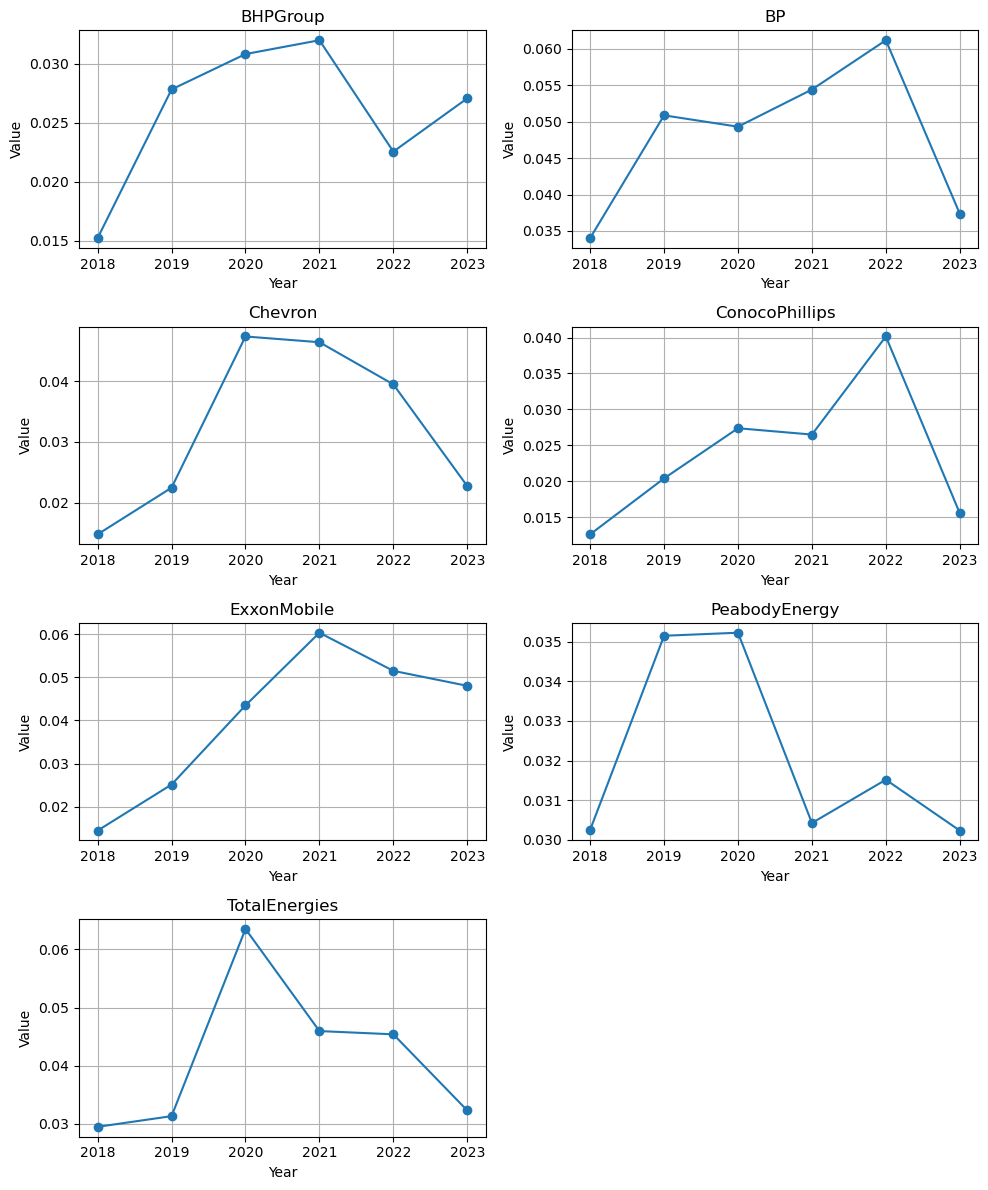

In [69]:
# Determine the layout of subplots
num_companies = len(df.columns)
cols = 2  # Number of columns in the subplot grid
rows = num_companies // cols + (num_companies % cols > 0)  # Calculate rows needed

# Create the subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 3 * rows))  # Adjust size as needed
axes = axes.flatten()  # Flatten to 1D if necessary

# Plot data for each company in a separate subplot
for i, (company, values) in enumerate(df.items()):
    ax = axes[i]
    ax.plot(df.index, values, marker='o', linestyle='-')
    ax.set_title(company)
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.grid(True)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

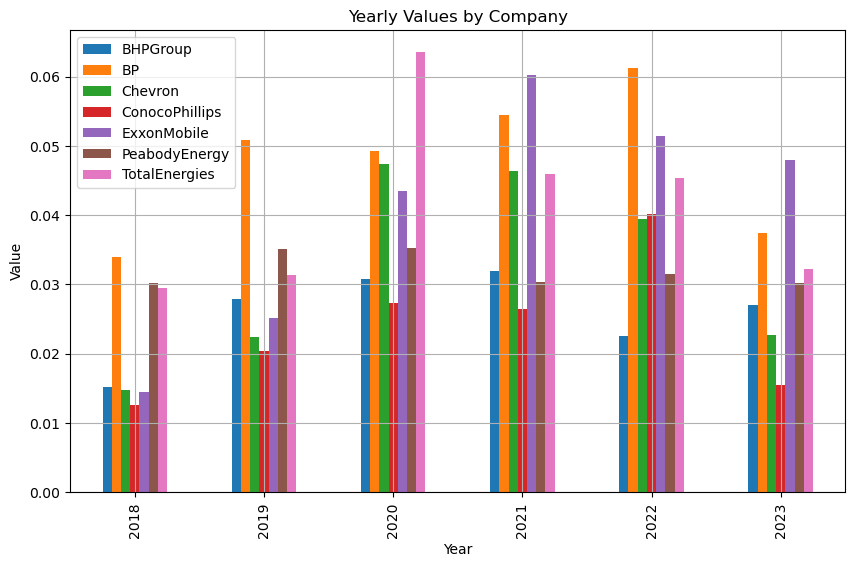

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(kind='bar', ax=ax)
ax.set_title('Yearly Values by Company')
ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.grid(True)
plt.show()


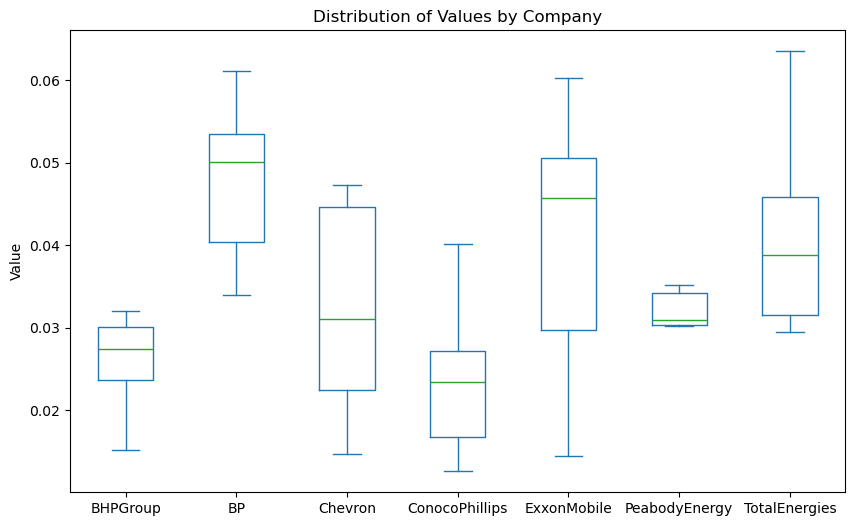

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(kind='box', ax=ax)
ax.set_title('Distribution of Values by Company')
ax.set_ylabel('Value')
plt.show()


In [ ]:
del df

In [ ]:
# Going up over the years for most of the firms except TotalEnergies and Peabody Energy
# Might be showing stricter climate regulations they are facing 

In [ ]:
# regulatory - stable/specific keywords
## prob does not vary for oil and gas 
# grouped with specific words
# cap and trade
# similarity score (or keywords)

In [ ]:
# dropped 2024 since there is only one quarter

In [ ]:
# Q1,2,3,4
# delete Q, A, names